# Sales Data Analysis

### Importing libraries

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import csv

# Assignment Tasks

## 1. Creating an sqlite database file

In [ ]:
conn=sqlite3.connect("ecommerce.db")
cursor=conn.cursor()

## 2. Loading data

In [ ]:
Orders=pd.read_csv("Orders_Large.csv")
Products=pd.read_csv("Products_Large.csv")
Customers=pd.read_csv("Customers_Large.csv")
Sales=pd.read_csv("Sales_Large.csv")

## 3. Converting csv to sql tables

In [ ]:
Orders.to_sql("Orders",conn, if_exists="replace",index=False)
Products.to_sql("Products",conn, if_exists="replace",index=False)
Customers.to_sql("Customers",conn, if_exists="replace",index=False)
Sales.to_sql("Sales",conn, if_exists="replace",index=False)
print("Data sucessfuly loaded into sqlite database")

Data sucessfuly loaded into sqlite database


### Varify data

In [ ]:
Orders=pd.read_sql("select * from Orders",conn)
print(Orders.head())

   TransactionID   OrderDate  CustomerID  ProductID  Quantity  TotalAmount
0           1000  2023-02-11           6        212         4          426
1           1001  2024-06-09          22        226         8          184
2           1002  2022-12-11          31        231         5          880
3           1003  2022-12-18          23        227        10          928
4           1004  2024-04-11          42        215         7          517


In [ ]:
Products=pd.read_sql("select * from Products",conn)
print(Products.head())

   ProductID     ProductName         Category  Price
0        200          Report            Books     89
1        201           Shake      Electronics    226
2        202           Skill            Books    494
3        203            Into  Home Appliances    160
4        204  Responsibility            Books    479


In [ ]:
Customers=pd.read_sql("select * from Customers",conn)
print(Customers.head())

   CustomerID               Name   Region    Segment
0           1  Christina Harrell     East  Corporate
1           2      David Charles     East  Corporate
2           3      Cheryl Harris     East  Corporate
3           4       Cameron King  Central  Corporate
4           5          Tanya Kim     West  Corporate


In [ ]:
Sales=pd.read_sql("select * from Sales",conn)
print(Sales.head())

   OrderID  Revenue  Discounts  Taxes
0     1000     1755         30     65
1     1001     1727         76    101
2     1002     1834         25     23
3     1003      896         94    123
4     1004     1868         51     63


###  Joining all tabels to create a single table

In [ ]:
# Create customorder table
cursor.execute("""
CREATE TABLE IF NOT EXISTS customorder AS
SELECT
    c.CustomerID,
    c.Name,
    c.Region,
    c.Segment,
    o.TransactionID,
    o.OrderDate,
    o.ProductID,
    o.Quantity,
    o.TotalAmount
FROM Customers c
JOIN Orders o ON c.CustomerID = o.CustomerID;
""")

# Create procustomorder table
cursor.execute("""
CREATE TABLE IF NOT EXISTS procustomorder AS
SELECT
    p.ProductID,
    p.ProductName,
    p.Category,
    p.Price,
    co.CustomerID,
    co.Name,
    co.Region,
    co.Segment,
    co.TransactionID,
    co.OrderDate,
    co.Quantity,
    co.TotalAmount
FROM Products p
JOIN customorder co ON co.ProductID = p.ProductID;
""")

# Create sales_data table
cursor.execute("""
CREATE TABLE IF NOT EXISTS sales_data AS
SELECT
    s.OrderID,
    s.Revenue,
    s.Discounts,
    s.Taxes,
    co.ProductID,
    co.ProductName,
    co.Category,
    co.Price,
    co.CustomerID,
    co.Name,
    co.Region,
    co.Segment,
    co.OrderDate,
    co.Quantity,
    co.TotalAmount
FROM Sales s
JOIN procustomorder co ON co.TransactionID = s.OrderID;
""")

# Commit the transaction and close the connection
conn.commit()

### 6. Varify table is created or not

In [ ]:
# Reconnect to the SQLite database
sales_data = pd.read_sql("SELECT * FROM sales_data", conn)
print(sales_data.head())

   OrderID  Revenue  Discounts  Taxes  ProductID ProductName         Category  \
0     1000     1755         30     65        212        Mind      Accessories   
1     1001     1727         76    101        226      Suffer      Accessories   
2     1002     1834         25     23        231        Role  Home Appliances   
3     1003      896         94    123        227       North  Home Appliances   
4     1004     1868         51     63        215        Both      Accessories   

   Price  CustomerID          Name   Region    Segment   OrderDate  Quantity  \
0     67           6  Lauren Walls     West  Wholesale  2023-02-11         4   
1    179          22     Lori Cole  Central  Wholesale  2024-06-09         8   
2     82          31   Sherri Knox    South  Wholesale  2022-12-11         5   
3    221          23    Randy Duke    North     Retail  2022-12-18        10   
4    334          42   Zachary Ray  Central  Corporate  2024-04-11         7   

   TotalAmount  
0          426 

# 4. Performing SQL Queries

### 1. Total sales revenue by month

In [ ]:
query="""select
strftime("%Y-%m",Orderdate) as month,
sum(Revenue) as TotalRevenue
from sales_data
group by month
order by month asc;
"""
cursor.execute(query)
sales_revenue_by_month = cursor.fetchall()
# Open a CSV file for writing
with open('revenue_by_month.csv', 'w', newline='') as csvfile:
    # Create a CSV writer object
    csv_writer = csv.writer(csvfile)
    # Write the header row
    csv_writer.writerow(['month', 'TotalRevenue'])
    # Write the data rows
    for row in sales_revenue_by_month:
        csv_writer.writerow(row)

In [ ]:
data1=pd.read_csv('revenue_by_month.csv')
data1

,month,TotalRevenue
0,2022-11,9336
1,2022-12,26988
2,2023-01,20160
3,2023-02,17371
4,2023-03,19860
5,2023-04,21539
6,2023-05,24469
7,2023-06,19051
8,2023-07,27406
9,2023-08,23560


### 2. Top 5 best-selling products

In [ ]:
query="""select
ProductName, sum(Revenue) as top_best_selling_product
from sales_data
group by ProductName
order by top_best_selling_product desc
limit 5;
"""
cursor.execute(query)
top_best_selling_product = cursor.fetchall()
# Open a CSV file for writing
with open('best_selling_product.csv', 'w', newline='') as csvfile:
    # Create a CSV writer object
    csv_writer = csv.writer(csvfile)
    # Write the header row
    csv_writer.writerow(['ProductName', 'top_best_selling_product'])
    # Write the data rows
    for row in top_best_selling_product:
        csv_writer.writerow(row)

In [ ]:
data2=pd.read_csv('best_selling_product.csv')
data2

,ProductName,top_best_selling_product
0,Notice,28515
1,Both,19651
2,Hope,17570
3,Role,16135
4,Answer,15646


### 3. Revenue contribution by customer segments

In [ ]:

query="""select
segment, sum(Revenue) as Revenue_contribution_by_segement
from sales_data
group by segment
order by Revenue_contribution_by_segement desc;
"""

cursor.execute(query)
revenue_contribution_by_segment = cursor.fetchall()

# Open a CSV file for writing
with open('revenue_by_segment.csv', 'w', newline='') as csvfile:
    # Create a CSV writer object
    csv_writer = csv.writer(csvfile)

    # Write the header row
    csv_writer.writerow(['segment', 'revenue_by_segment'])

    # Write the data rows
    for row in revenue_contribution_by_segment:
        csv_writer.writerow(row)

In [ ]:
data3=pd.read_csv('revenue_by_segment.csv')
data3

,segment,revenue_by_segment
0,Corporate,249656
1,Wholesale,158455
2,Retail,136538


### 4. Identify the top regions for sales

In [ ]:
query = """
SELECT Region, SUM(Revenue) AS TotalRevenue
FROM sales_data
GROUP BY Region
ORDER BY TotalRevenue DESC;
"""

cursor.execute(query)
revenue_contribution_by_region = cursor.fetchall()

# Open a CSV file for writing
with open('revenue_by_region.csv', 'w', newline='') as csvfile:
    # Create a CSV writer object
    csv_writer = csv.writer(csvfile)

    # Write the header row
    csv_writer.writerow(['Region', 'TotalRevenue'])

    # Write the data rows
    for row in revenue_contribution_by_region:
        csv_writer.writerow(row)

In [ ]:
data4=pd.read_csv('revenue_by_region.csv')
data4

,Region,TotalRevenue
0,West,155950
1,Central,127614
2,East,117258
3,North,89733
4,South,54094


# 5. EDA and Data Visualization

### Converting sql table to csv file

In [ ]:
# Load the SQL table into a DataFrame
sales_data = pd.read_sql("SELECT * FROM sales_data", conn)

# Save the DataFrame to a CSV file
sales_data.to_csv("sales_data.csv", index=False)
print(f"Data successfully exported to sales_data.csv")



Data successfully exported to sales_data.csv


### displaying data

In [ ]:
df=pd.read_csv("sales_data.csv")

In [ ]:
df.head(5)

,OrderID,Revenue,Discounts,Taxes,ProductID,ProductName,Category,Price,CustomerID,Name,Region,Segment,OrderDate,Quantity,TotalAmount
0,1000,1755,30,65,212,Mind,Accessories,67,6,Lauren Walls,West,Wholesale,2023-02-11,4,426
1,1001,1727,76,101,226,Suffer,Accessories,179,22,Lori Cole,Central,Wholesale,2024-06-09,8,184
2,1002,1834,25,23,231,Role,Home Appliances,82,31,Sherri Knox,South,Wholesale,2022-12-11,5,880
3,1003,896,94,123,227,North,Home Appliances,221,23,Randy Duke,North,Retail,2022-12-18,10,928
4,1004,1868,51,63,215,Both,Accessories,334,42,Zachary Ray,Central,Corporate,2024-04-11,7,517


In [ ]:
df.shape

(484, 15)

### Handling Missing data

In [ ]:
df.isnull().sum()

,0
OrderID,0
Revenue,0
Discounts,0
Taxes,0
ProductID,0
ProductName,0
Category,0
Price,0
CustomerID,0
Name,0


#### There is no missing data so no need to handle it

### Handling Duplicates

In [ ]:
df.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
479,False
480,False
481,False
482,False


There are no duplicate values in data

### Exploring data Analysis

In [ ]:
unique_categories=df["Category"].unique()
print(unique_categories)

['Accessories' 'Home Appliances' 'Electronics' 'Books']


In [ ]:
unique_categories=df["ProductName"].unique()
print(unique_categories)

['Mind' 'Suffer' 'Role' 'North' 'Both' 'Dog' 'Care' 'Happen' 'Maybe'
 'Heavy' 'Explain' 'Card' 'Nor' 'Level' 'Pull' 'System' 'Your' 'Present'
 'Just' 'Story' 'Catch' 'Answer' 'Shake' 'Into' 'Protect' 'Notice' 'Size'
 'Despite' 'Gun' 'Dream' 'Friend' 'Price' 'Hope' 'Available' 'Like' 'We'
 'Guess' 'Process' 'Argue' 'Skill' 'Performance' 'Enter' 'Truth'
 'Responsibility' 'Behavior' 'Guy' 'Voice' 'Dinner']


## Data Visualization

## 1. Sales by month

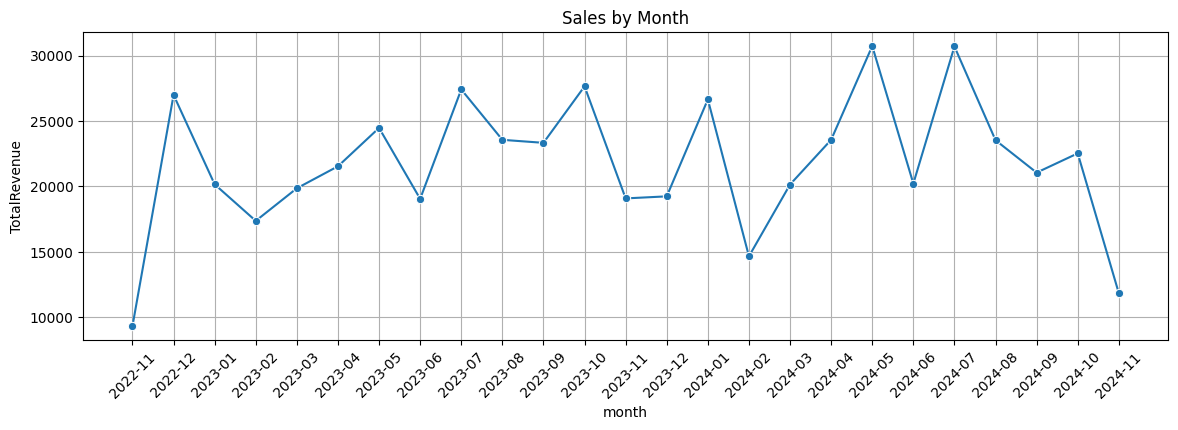

In [ ]:
plt.figure(figsize=(14, 4))
sns.lineplot(x="month", y="TotalRevenue", data=data1, marker="o")
plt.title("Sales by Month")
plt.grid()
plt.xticks(rotation=45)
plt.show()

## 2. Top Selling Products

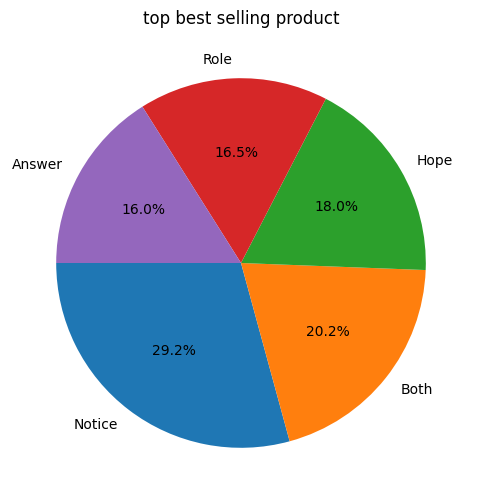

In [ ]:
plt.figure(figsize=(6,6))
plt.pie(data2["top_best_selling_product"],labels=data2["ProductName"],autopct="%1.1f%%",startangle=180)
plt.title("top best selling product")
plt.show()

## 3. Revenue by Customer segment

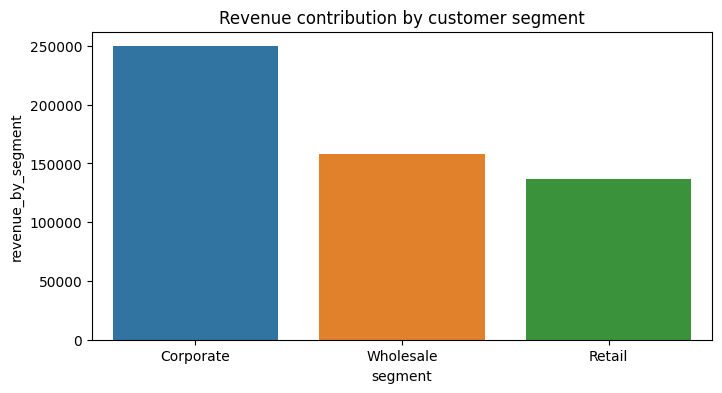

In [ ]:
plt.figure(figsize=(8, 4))
sns.barplot(x="segment",y="revenue_by_segment",data=data3,hue="segment")
plt.title("Revenue contribution by customer segment")
plt.show()

## 4. Revenue by Region

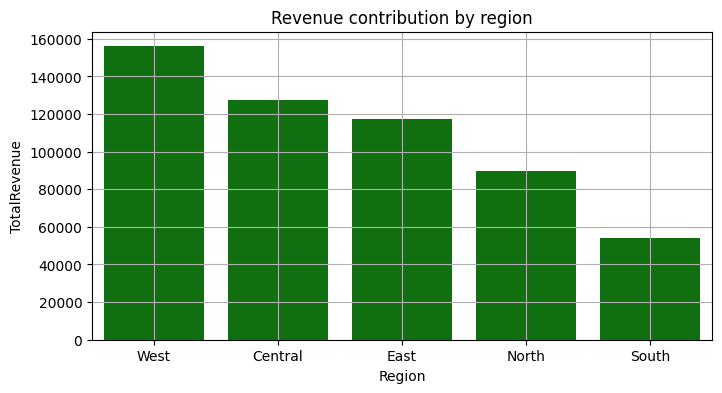

In [ ]:
plt.figure(figsize=(8, 4))
sns.barplot(x="Region",y="TotalRevenue",data=data4,color="green")
plt.title("Revenue contribution by region")
plt.grid()
plt.show()

## 5. HIghest Quantity ordered on which date by which customer

In [ ]:
df.loc[df["Quantity"].idxmax(),["OrderDate","Name","Quantity"]]

,3
OrderDate,2022-12-18
Name,Randy Duke
Quantity,10


## 6. Highest Tax by Category

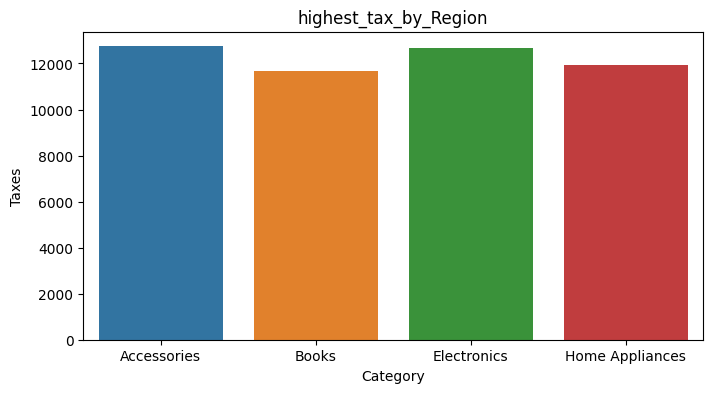

In [ ]:
highest_tax_by_category=df.groupby("Category")["Taxes"].sum().reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(x="Category",y="Taxes",hue="Category",data=highest_tax_by_category, legend=False  )
plt.title("highest_tax_by_Region")
plt.show()

## 7. Highest Tax by Segement

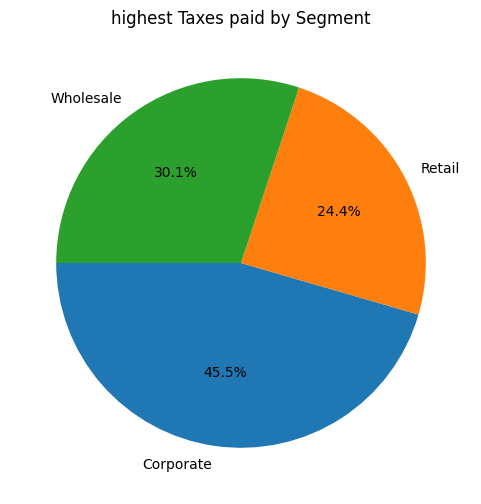

In [ ]:
highest_tax_by_Segment=df.groupby("Segment")["Taxes"].sum().reset_index()
plt.figure(figsize=(6,6))
plt.pie(highest_tax_by_Segment["Taxes"],labels=highest_tax_by_Segment["Segment"],autopct="%1.1f%%",startangle=180)
plt.title("highest Taxes paid by Segment")
plt.show()

## 8. Highest Tax by Region

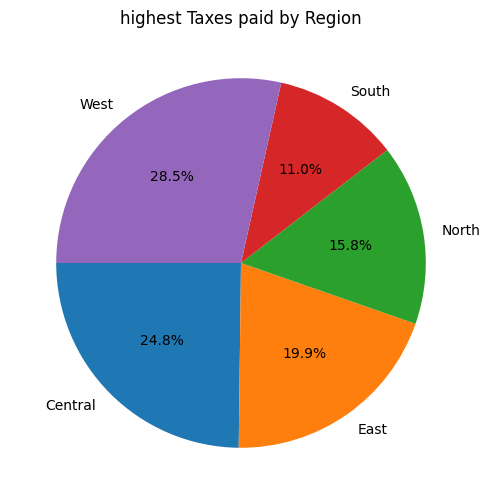

In [ ]:
highest_tax_by_Region=df.groupby("Region")["Taxes"].sum().reset_index()
plt.figure(figsize=(6,6))
plt.pie(highest_tax_by_Region["Taxes"],labels=highest_tax_by_Region["Region"],autopct="%1.1f%%",startangle=180)
plt.title("highest Taxes paid by Region")
plt.show()